# **Capstone Module 3**

The goal of this project is to create a prediction model to accurately predict the customers who will potentially churn based on the data of the features collected in the dataset provided.
<br>
With that, we need to catch all churners

## Import Libraries

In [459]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import mannwhitneyu
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

import pickle


## Load Dataset

In [460]:
df = pd.read_csv("data_ecommerce_customer_churn.csv")
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


## Data Cleaning & EDA

In [461]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [462]:
# check duplicates
df.duplicated().sum()

np.int64(671)

In [463]:
# drop duplicates
df = df.drop_duplicates()

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3270 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3110 non-null   float64
 1   WarehouseToHome           3135 non-null   float64
 2   NumberOfDeviceRegistered  3270 non-null   int64  
 3   PreferedOrderCat          3270 non-null   object 
 4   SatisfactionScore         3270 non-null   int64  
 5   MaritalStatus             3270 non-null   object 
 6   NumberOfAddress           3270 non-null   int64  
 7   Complain                  3270 non-null   int64  
 8   DaySinceLastOrder         3089 non-null   float64
 9   CashbackAmount            3270 non-null   float64
 10  Churn                     3270 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 306.6+ KB


In [465]:
df.describe(include="all")

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3110.000000,3135.000000,3270.000000,3270,3270.000000,3270,3270.000000,3270.000000,3089.000000,3270.000000,3270.000000
unique,NaN,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1213,NaN,1686,NaN,NaN,NaN,NaN,NaN
mean,10.190354,15.510367,3.676453,NaN,3.020795,NaN,4.222936,0.281651,4.545484,177.417670,0.163303
std,8.650821,8.568382,1.017390,NaN,1.395113,NaN,2.623195,0.449873,3.696022,49.310647,0.369698
min,0.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,2.000000,145.892500,0.000000
50%,9.000000,13.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,3.000000,163.885000,0.000000
75%,16.000000,20.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,7.000000,197.137500,0.000000


In [466]:
# check unique values of categorical variables - PreferedOrderCat
df["PreferedOrderCat"].unique()

array(['Laptop & Accessory', 'Mobile', 'Fashion', 'Others',
       'Mobile Phone', 'Grocery'], dtype=object)

In [467]:
# check unique values of categorical variables - MaritalStatus
df["MaritalStatus"].unique()

array(['Single', 'Married', 'Divorced'], dtype=object)

In [468]:
df["Complain"].unique()

array([0, 1])

In [469]:
# target variable analysis - check balance of dataset
df["Churn"].value_counts()

Churn
0    2736
1     534
Name: count, dtype: int64

In [470]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.836697
1    0.163303
Name: proportion, dtype: float64

dataset is not balanced

Text(0.5, 1.0, 'Countplot of Churned Customers in the Dataset')

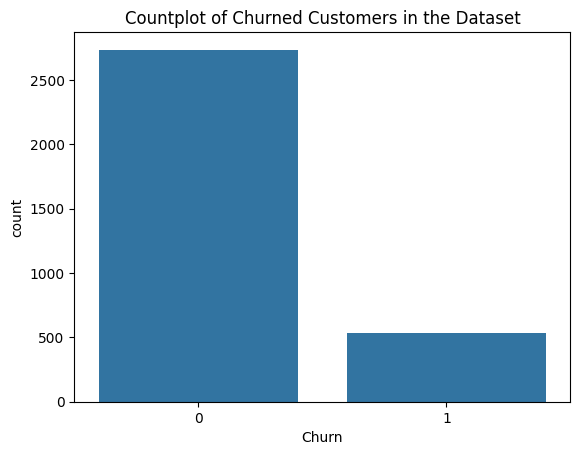

In [471]:
sns.countplot(data = df, x = "Churn")
plt.title("Countplot of Churned Customers in the Dataset")

In [472]:
# check missing values
df.isna().sum()

Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64

Matrix Plot

<Axes: >

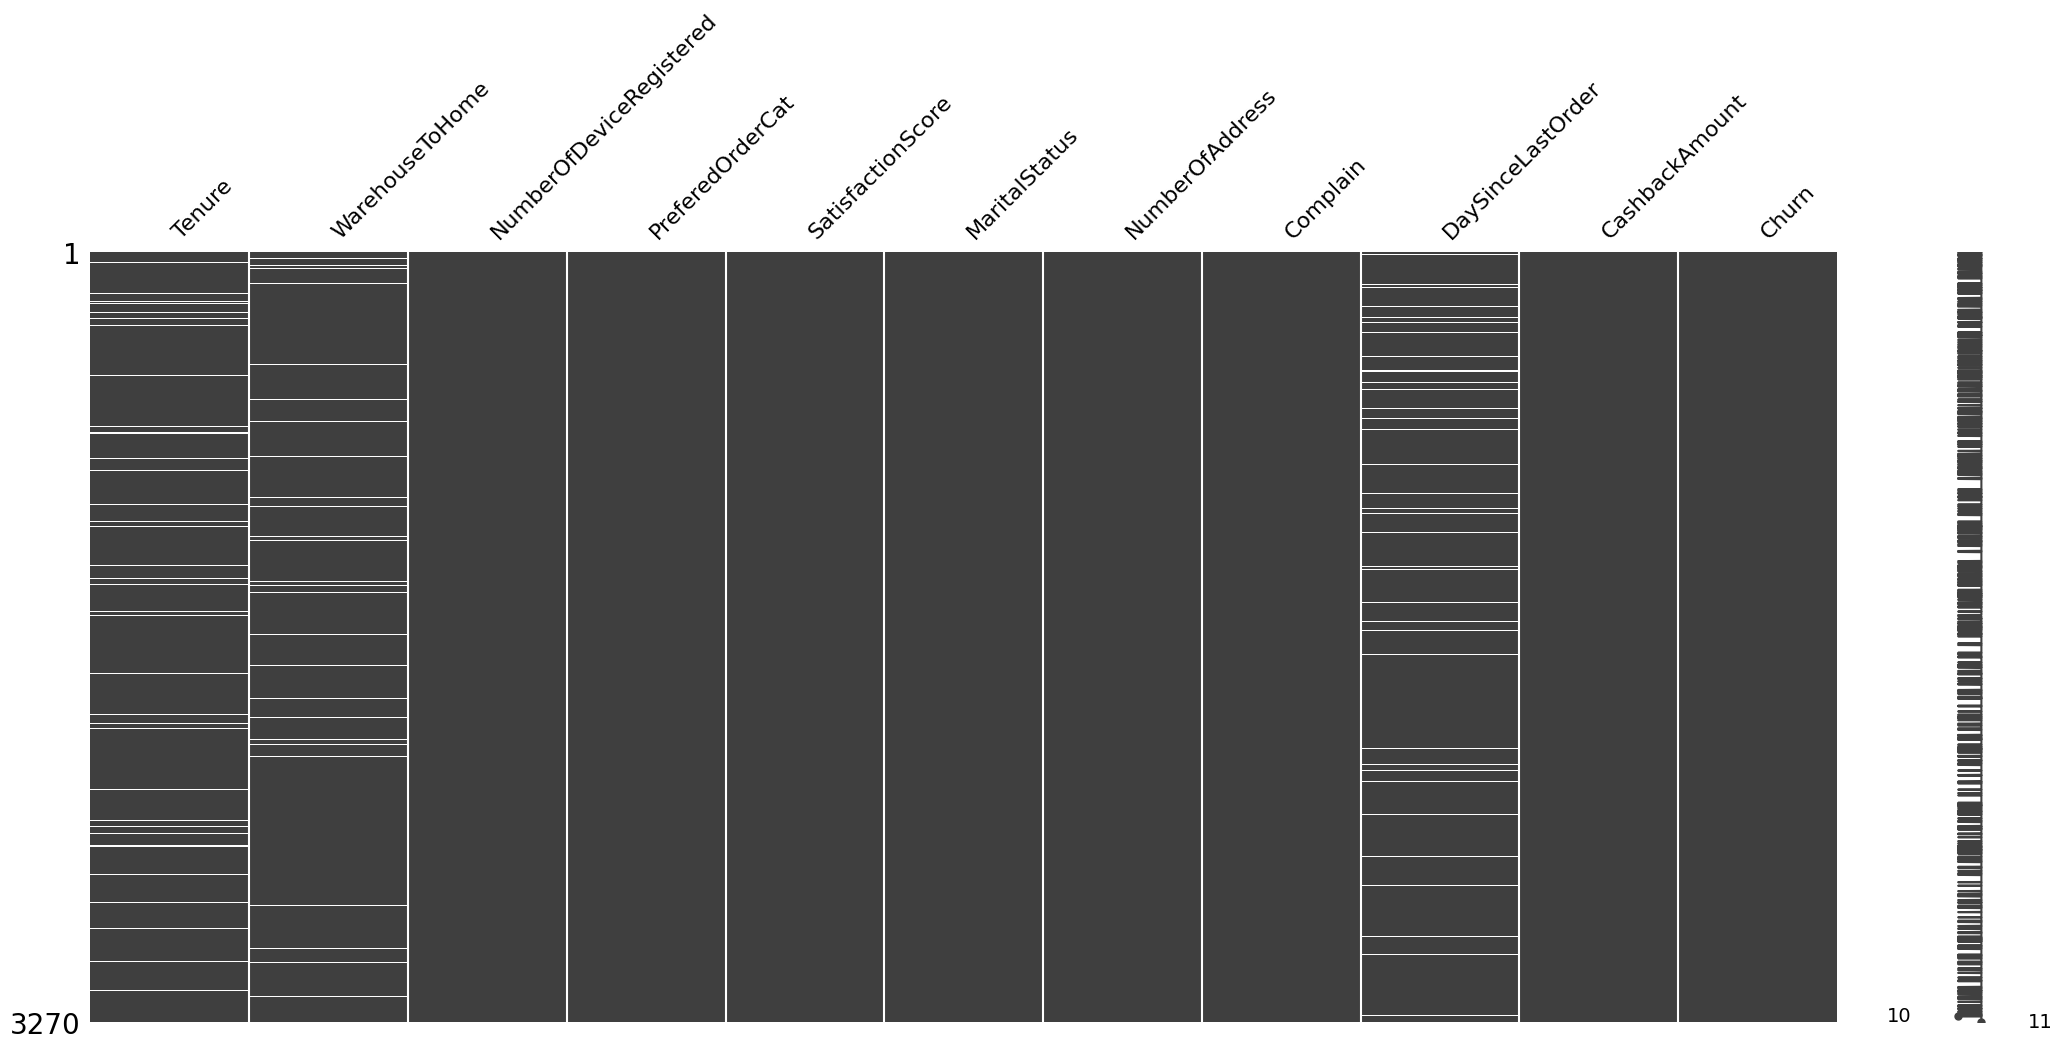

In [473]:
msno.matrix(df)

matrix plot shows missing values in each column does not have a pattern

<Axes: >

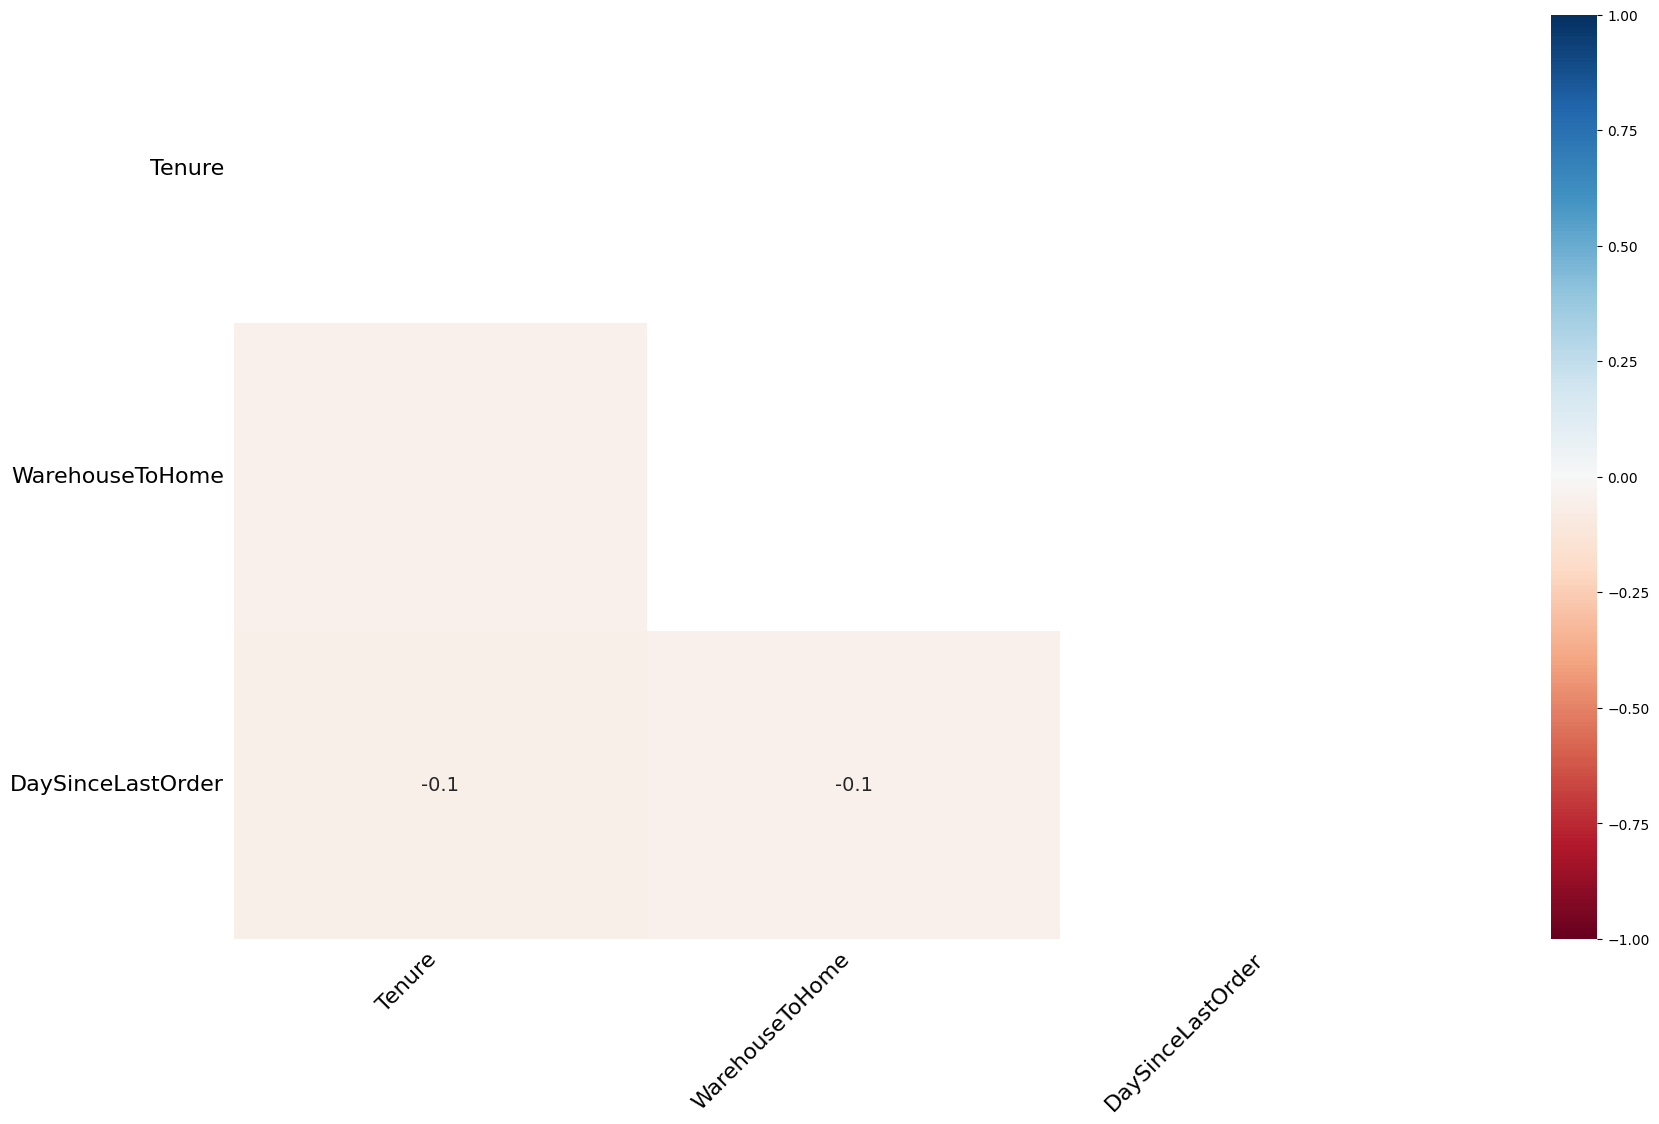

In [474]:
msno.heatmap(df)

heatmap shows that the missing values between each columns does not have a correlation

### Numerical Features Distribution

In [475]:
# distribution without dropping missing values
df.describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3110.000000,3135.000000,3270.000000,3270.000000,3270.000000,3270.000000,3089.000000,3270.000000,3270.000000
mean,10.190354,15.510367,3.676453,3.020795,4.222936,0.281651,4.545484,177.417670,0.163303
std,8.650821,8.568382,1.017390,1.395113,2.623195,0.449873,3.696022,49.310647,0.369698
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.892500,0.000000
50%,9.000000,13.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.885000,0.000000
75%,16.000000,20.000000,4.000000,4.000000,6.000000,1.000000,7.000000,197.137500,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


In [476]:
# distribution after dropping missing values
df.dropna().describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000
mean,10.284896,15.560129,3.698998,3.025412,4.283107,0.283107,4.784896,180.412058,0.147101
std,8.665384,8.636022,1.023508,1.395250,2.623741,0.450588,3.720533,48.885374,0.354270
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,148.485000,0.000000
50%,9.000000,13.000000,4.000000,3.000000,3.000000,0.000000,4.000000,165.360000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,8.000000,192.925000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


data dsitribution from numerical features before and after removing null data is similar. where it can be seen from teh mean and standard deviation

In [477]:
df["Churn"].value_counts()

Churn
0    2736
1     534
Name: count, dtype: int64

In [478]:
df.dropna()["Churn"].value_counts()

Churn
0    2383
1     411
Name: count, dtype: int64

In [479]:
df["Churn"].value_counts()/len(df["Churn"]) * 100

Churn
0    83.669725
1    16.330275
Name: count, dtype: float64

In [480]:
df.dropna()["Churn"].value_counts()/len(df.dropna()["Churn"]) * 100

Churn
0    85.289907
1    14.710093
Name: count, dtype: float64

it can be seen above that the distribution of tha target is the same before and after removing null data

### Categorical Features Distribution

In [481]:
df.describe(include=["O"])

,PreferedOrderCat,MaritalStatus
count,3270,3270
unique,6,3
top,Laptop & Accessory,Married
freq,1213,1686


In [482]:
df.dropna().describe(include=['O'])

,PreferedOrderCat,MaritalStatus
count,2794,2794
unique,6,3
top,Laptop & Accessory,Married
freq,1170,1452


the above shows that there is no missing values in these categorical features

### Visualisation

Text(0.5, 1.0, 'Marital Status Bar Graph')

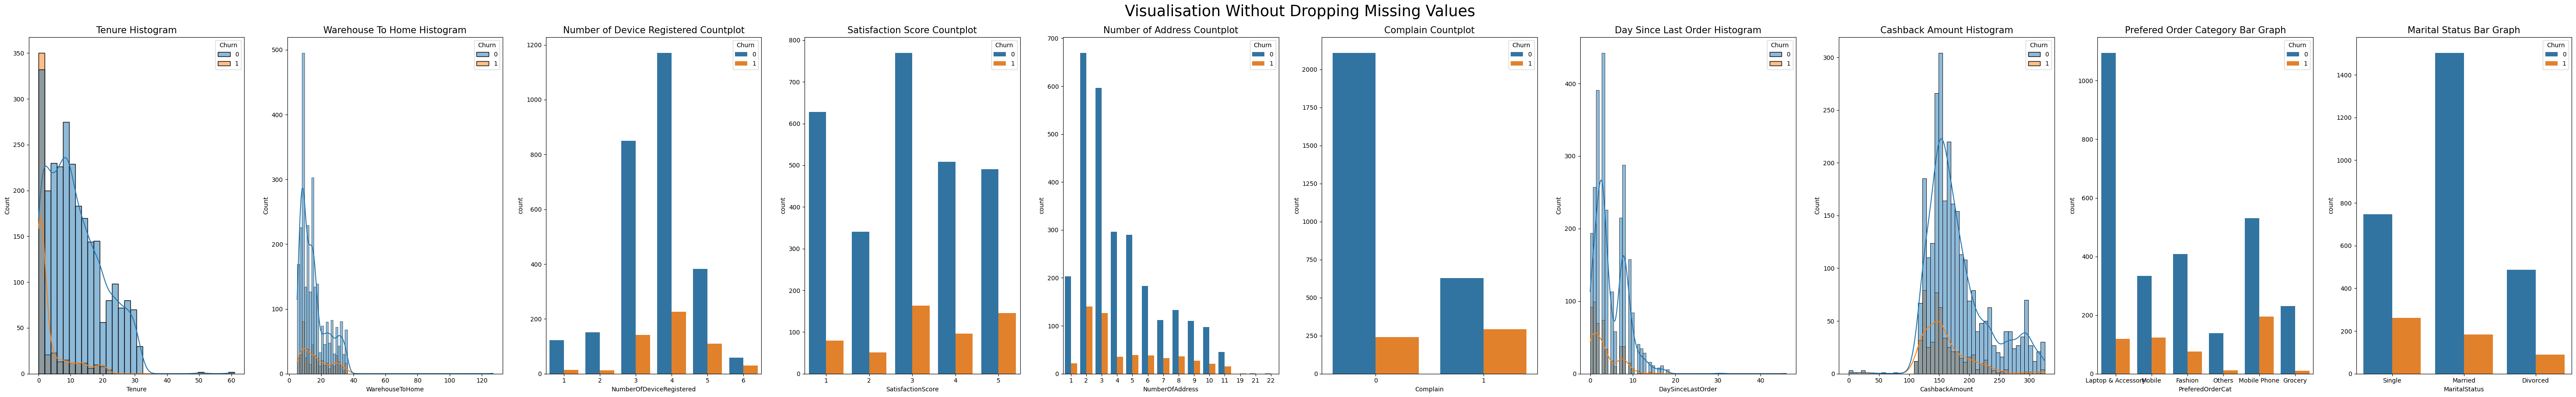

In [483]:
# before dropping missing values
plt.figure(figsize=(75,10))
plt.title("Visualisation Without Dropping Missing Values\n", fontsize = 25)
plt.box(on= None)
plt.axis("off")

plt.subplot(1, 10, 1)
sns.histplot(data = df, x= "Tenure", hue = "Churn", kde = True)
plt.title("Tenure Histogram", fontsize = 15)

plt.subplot(1, 10, 2)
sns.histplot(data = df, x = "WarehouseToHome", hue = "Churn", kde = True)
plt.title("Warehouse To Home Histogram", fontsize = 15)

plt.subplot(1, 10, 3)
sns.countplot(data = df, x = "NumberOfDeviceRegistered", hue = "Churn")
plt.title("Number of Device Registered Countplot", fontsize = 15)

plt.subplot(1, 10, 4)
sns.countplot(data = df, x = "SatisfactionScore", hue = "Churn")
plt.title("Satisfaction Score Countplot", fontsize = 15)

plt.subplot(1, 10, 5)
sns.countplot(data = df, x = "NumberOfAddress", hue = "Churn")
plt.title("Number of Address Countplot", fontsize = 15)

plt.subplot(1, 10, 6)
sns.countplot(data = df, x = "Complain", hue = "Churn")
plt.title("Complain Countplot", fontsize = 15)

plt.subplot(1, 10, 7)
sns.histplot(data = df, x= "DaySinceLastOrder", hue = "Churn", kde = True)
plt.title("Day Since Last Order Histogram", fontsize = 15)

plt.subplot(1, 10, 8)
sns.histplot(data = df, x= "CashbackAmount", hue = "Churn", kde = True)
plt.title("Cashback Amount Histogram", fontsize = 15)

plt.subplot(1, 10, 9)
sns.countplot(data = df, x= "PreferedOrderCat", hue = "Churn")
plt.title("Prefered Order Category Bar Graph", fontsize = 15)

plt.subplot(1, 10, 10)
sns.countplot(data = df, x= "MaritalStatus", hue = "Churn")
plt.title("Marital Status Bar Graph", fontsize = 15)


In [484]:
df_before = df.copy()
df_after = df.dropna()

Text(0.5, 1.0, 'Marital Status Bar Graph')

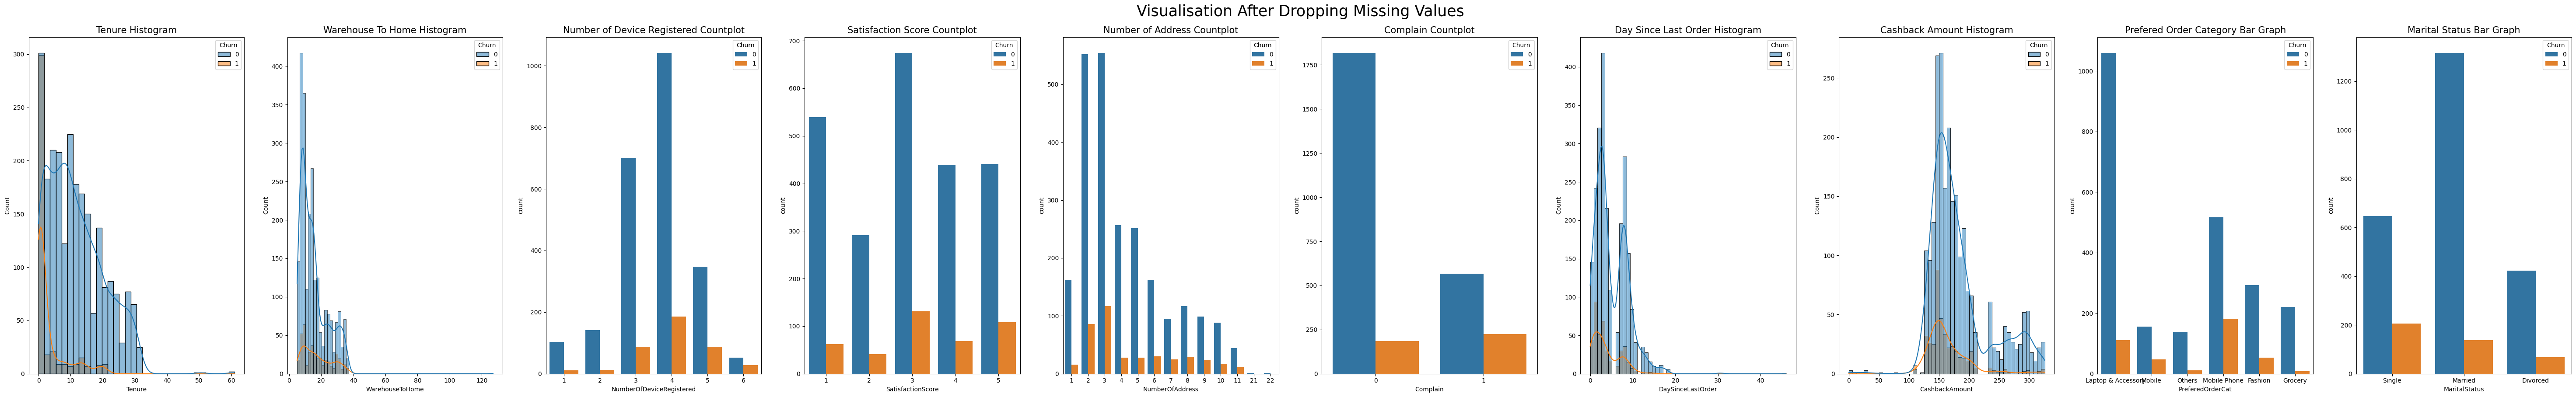

In [485]:
# after dropping missing values
df_after = df.dropna()
plt.figure(figsize=(75,10))
plt.title("Visualisation After Dropping Missing Values\n", fontsize = 25)
plt.box(on= None)
plt.axis("off")

plt.subplot(1, 10, 1)
sns.histplot(data = df_after, x= "Tenure", hue = "Churn", kde = True)
plt.title("Tenure Histogram", fontsize = 15)

plt.subplot(1, 10, 2)
sns.histplot(data = df_after, x = "WarehouseToHome", hue = "Churn", kde = True)
plt.title("Warehouse To Home Histogram", fontsize = 15)

plt.subplot(1, 10, 3)
sns.countplot(data = df_after, x = "NumberOfDeviceRegistered", hue = "Churn")
plt.title("Number of Device Registered Countplot", fontsize = 15)

plt.subplot(1, 10, 4)
sns.countplot(data = df_after, x = "SatisfactionScore", hue = "Churn")
plt.title("Satisfaction Score Countplot", fontsize = 15)

plt.subplot(1, 10, 5)
sns.countplot(data = df_after, x = "NumberOfAddress", hue = "Churn")
plt.title("Number of Address Countplot", fontsize = 15)

plt.subplot(1, 10, 6)
sns.countplot(data = df_after, x = "Complain", hue = "Churn")
plt.title("Complain Countplot", fontsize = 15)

plt.subplot(1, 10, 7)
sns.histplot(data = df_after, x= "DaySinceLastOrder", hue = "Churn", kde = True)
plt.title("Day Since Last Order Histogram", fontsize = 15)

plt.subplot(1, 10, 8)
sns.histplot(data = df_after, x= "CashbackAmount", hue = "Churn", kde = True)
plt.title("Cashback Amount Histogram", fontsize = 15)

plt.subplot(1, 10, 9)
sns.countplot(data = df_after, x= "PreferedOrderCat", hue = "Churn")
plt.title("Prefered Order Category Bar Graph", fontsize = 15)

plt.subplot(1, 10, 10)
sns.countplot(data = df_after, x= "MaritalStatus", hue = "Churn")
plt.title("Marital Status Bar Graph", fontsize = 15)

visualisation shows that there is no difference in distributions before and after dropping missing values
<br>
dropping missing values is justified

In [486]:
df = df.dropna()

### Outliers

In [487]:
# tenure
df = df[df["Tenure"] < 40]

# warehouse to home
df = df[df["WarehouseToHome"] < 60]

# days since last order
df = df[df["DaySinceLastOrder"] < 25]

# cashback
df = df[df["CashbackAmount"] > 80]

Text(0.5, 1.0, 'Marital Status Bar Graph')

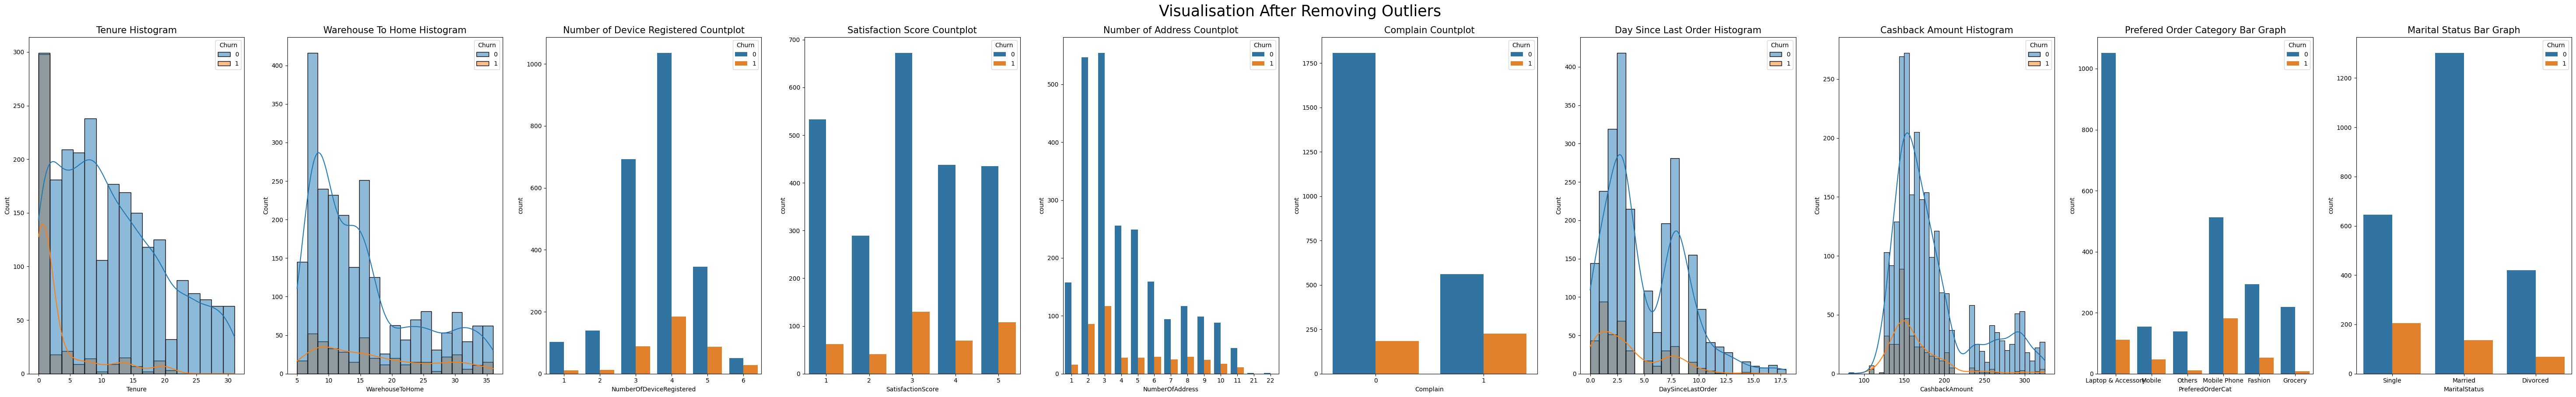

In [488]:
plt.figure(figsize=(75,10))
plt.title("Visualisation After Removing Outliers\n", fontsize = 25)
plt.box(on= None)
plt.axis("off")

plt.subplot(1, 10, 1)
sns.histplot(data = df, x= "Tenure", hue = "Churn", kde = True)
plt.title("Tenure Histogram", fontsize = 15)

plt.subplot(1, 10, 2)
sns.histplot(data = df, x = "WarehouseToHome", hue = "Churn", kde = True)
plt.title("Warehouse To Home Histogram", fontsize = 15)

plt.subplot(1, 10, 3)
sns.countplot(data = df, x = "NumberOfDeviceRegistered", hue = "Churn")
plt.title("Number of Device Registered Countplot", fontsize = 15)

plt.subplot(1, 10, 4)
sns.countplot(data = df, x = "SatisfactionScore", hue = "Churn")
plt.title("Satisfaction Score Countplot", fontsize = 15)

plt.subplot(1, 10, 5)
sns.countplot(data = df, x = "NumberOfAddress", hue = "Churn")
plt.title("Number of Address Countplot", fontsize = 15)

plt.subplot(1, 10, 6)
sns.countplot(data = df, x = "Complain", hue = "Churn")
plt.title("Complain Countplot", fontsize = 15)

plt.subplot(1, 10, 7)
sns.histplot(data = df, x= "DaySinceLastOrder", hue = "Churn", kde = True)
plt.title("Day Since Last Order Histogram", fontsize = 15)

plt.subplot(1, 10, 8)
sns.histplot(data = df, x= "CashbackAmount", hue = "Churn", kde = True)
plt.title("Cashback Amount Histogram", fontsize = 15)

plt.subplot(1, 10, 9)
sns.countplot(data = df, x= "PreferedOrderCat", hue = "Churn")
plt.title("Prefered Order Category Bar Graph", fontsize = 15)

plt.subplot(1, 10, 10)
sns.countplot(data = df, x= "MaritalStatus", hue = "Churn")
plt.title("Marital Status Bar Graph", fontsize = 15)


## Feature Engineering

### Split Features and Target

In [489]:
X = df.drop(columns="Churn")
y = df["Churn"]

### Multicollinearity

In [490]:
# one hot encoding
X_encoded = pd.get_dummies(X, drop_first=True,dtype=int)
X_encoded.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,15.0,29.0,4,3,2,0,7.0,143.32,0,1,0,0,0,0,1
1,7.0,25.0,4,1,2,0,7.0,129.29,0,0,1,0,0,1,0
2,27.0,13.0,3,1,5,0,7.0,168.54,0,1,0,0,0,1,0
4,30.0,15.0,4,4,8,0,8.0,322.17,0,0,0,0,1,0,1
5,7.0,16.0,4,2,2,0,11.0,152.81,0,0,0,1,0,0,0


In [491]:
# define model
model = sm.OLS(y, X_encoded) 

# fitting
model_result = model.fit()

# summary
print(model_result.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                  Churn   R-squared (uncentered):                   0.370
Model:                            OLS   Adj. R-squared (uncentered):              0.366
Method:                 Least Squares   F-statistic:                              108.0
Date:                Mon, 26 May 2025   Prob (F-statistic):                   3.28e-263
Time:                        01:00:47   Log-Likelihood:                         -643.36
No. Observations:                2777   AIC:                                      1317.
Df Residuals:                    2762   BIC:                                      1406.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [492]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(X_encoded.values, i) for i in range(X_encoded.shape[1])]

vif_data

,feature,VIF
0,Tenure,3.484358
1,WarehouseToHome,4.426645
2,NumberOfDeviceRegistered,16.423617
3,SatisfactionScore,5.657301
4,NumberOfAddress,4.140657
5,Complain,1.409954
6,DaySinceLastOrder,3.326099
7,CashbackAmount,35.696263
8,PreferedOrderCat_Grocery,2.345028
9,PreferedOrderCat_Laptop & Accessory,3.626490


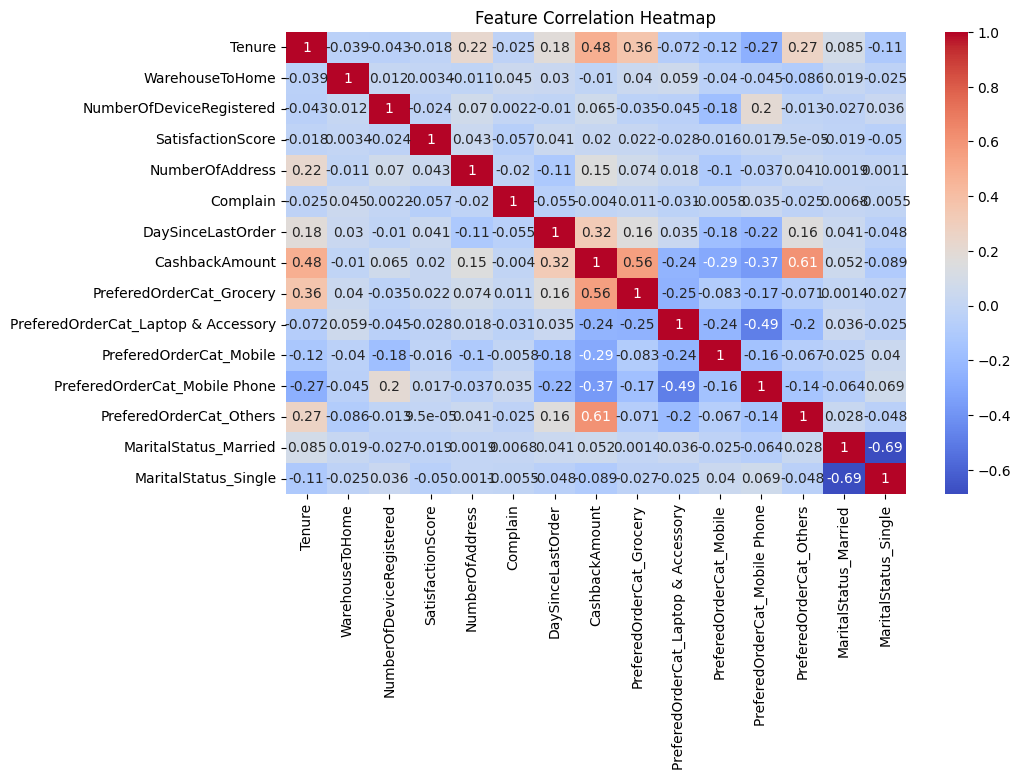

In [493]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_encoded.corr(), cmap='coolwarm', annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

## Train Test Set Split

In [494]:
X = df.drop(columns="Churn")
y = df["Churn"]

In [495]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Pipelines

In [496]:
# Separate features
numerical_features = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
                      'SatisfactionScore', 'NumberOfAddress', 'DaySinceLastOrder',
                      'CashbackAmount']

categorical_features = ['PreferedOrderCat', 'MaritalStatus']

# Pipeline for numerical features
numerical_pipeline = SkPipeline([
    ('imp_iterative', IterativeImputer()),
    ('robust', RobustScaler())
])

# Pipeline for categorical features
categorical_pipeline = SkPipeline([
    ('imp_mode', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine them
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [497]:
numerical_pipeline

Pipeline(steps=[('imp_iterative', IterativeImputer()),
                ('robust', RobustScaler())])

In [498]:
categorical_pipeline

Pipeline(steps=[('imp_mode', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])

## 1. Logistic Regression Model

In [499]:
logreg_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

In [500]:
# Fit the model
logreg_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_iterative',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression())])

In [501]:
# Predict
y_pred_lr = logreg_model_pipeline.predict(X_test)
y_proba_lr = logreg_model_pipeline.predict_proba(X_test)[:, 1]

In [502]:
# log reg model evaluation'
model_metrics = []

# Basic metrics
model_metrics.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'F2-Score': fbeta_score(y_test, y_pred_lr, beta=2),
    "ROC AUC Score:": roc_auc_score(y_test, y_proba_lr)
})

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Full classification report
print(classification_report(y_test, y_pred_lr))


Confusion Matrix:
 [[371 103]
 [ 22  60]]
              precision    recall  f1-score   support

           0       0.94      0.78      0.86       474
           1       0.37      0.73      0.49        82

    accuracy                           0.78       556
   macro avg       0.66      0.76      0.67       556
weighted avg       0.86      0.78      0.80       556



## 2. Decision Tree Classification

In [503]:
dt_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

In [504]:
# fit the model
dt_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_iterative',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [505]:
# predict
y_pred_dt = dt_model_pipeline.predict(X_test)

In [506]:
y_proba_dt = dt_model_pipeline.predict_proba(X_test)[:, 1]

# Basic metrics
model_metrics.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_proba_dt),
    'Precision': precision_score(y_test, y_proba_dt),
    'Recall': recall_score(y_test, y_proba_dt),
    'F1-Score': f1_score(y_test, y_proba_dt),
    'F2-Score': fbeta_score(y_test, y_proba_dt, beta=2),
    "ROC AUC Score:": roc_auc_score(y_test, y_proba_dt)
})

# Confusion matrix
print(confusion_matrix(y_test, y_proba_dt))

# Classification report
print(classification_report(y_test, y_proba_dt))

[[430  44]
 [ 28  54]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       474
           1       0.55      0.66      0.60        82

    accuracy                           0.87       556
   macro avg       0.74      0.78      0.76       556
weighted avg       0.88      0.87      0.88       556



## 3. Random Forest Classification

In [507]:
rf_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [508]:
# fit the model
rf_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_iterative',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [509]:
# predict
y_pred_rf = rf_model_pipeline.predict(X_test)

In [510]:
y_proba_rf = rf_model_pipeline.predict_proba(X_test)[:, 1]

# Basic metrics
model_metrics.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'F2-Score': fbeta_score(y_test, y_pred_rf, beta=2),
    "ROC AUC Score:": roc_auc_score(y_test, y_proba_rf)
})

# Confusion matrix
print(confusion_matrix(y_test, y_pred_rf))

# Classification report
print(classification_report(y_test, y_pred_rf))

[[448  26]
 [ 35  47]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       474
           1       0.64      0.57      0.61        82

    accuracy                           0.89       556
   macro avg       0.79      0.76      0.77       556
weighted avg       0.89      0.89      0.89       556



## 4.  XGBoost

In [511]:
xgb_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state = 42, use_label_encoder=False, eval_metric='logloss'))
])

In [512]:
# fit the model
xgb_model_pipeline.fit(X_train, y_train)

C:\Users\amfed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:00:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_iterative',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp_mode',
                                                                   SimpleImputer(strategy='most_fr...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [513]:
# predict
y_pred_xgb = xgb_model_pipeline.predict(X_test)

In [514]:
y_proba_xgb = xgb_model_pipeline.predict_proba(X_test)[:, 1] 

# basic metrics
model_metrics.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'F2-Score': fbeta_score(y_test, y_pred_xgb, beta=2),
    "ROC AUC Score:": roc_auc_score(y_test, y_proba_xgb)
})

# confusion matrix
print(confusion_matrix(y_test, y_pred_xgb))

# full classification report
print(classification_report(y_test, y_pred_xgb))


[[448  26]
 [ 32  50]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       474
           1       0.66      0.61      0.63        82

    accuracy                           0.90       556
   macro avg       0.80      0.78      0.79       556
weighted avg       0.89      0.90      0.89       556



## 5. KNN

In [515]:
knn_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=1))
])

In [516]:
# fit the model
knn_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_iterative',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', KNeighborsClassifier(n_neighbors=1))])

In [517]:
# predict
y_pred_knn = knn_model_pipeline.predict(X_test)

In [518]:
y_proba_knn = knn_model_pipeline.predict_proba(X_test)[:, 1] 

# basic metrics
model_metrics.append({
    'Model': 'KNN',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1-Score': f1_score(y_test, y_pred_knn),
    'F2-Score': fbeta_score(y_test, y_pred_knn, beta=2),
    "ROC AUC Score:": roc_auc_score(y_test, y_proba_knn)
})

# confusion matrix
print(confusion_matrix(y_test, y_pred_knn))

# full classification report
print(classification_report(y_test, y_pred_knn))

[[429  45]
 [ 38  44]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       474
           1       0.49      0.54      0.51        82

    accuracy                           0.85       556
   macro avg       0.71      0.72      0.71       556
weighted avg       0.86      0.85      0.85       556



In [519]:
# results
results_df = pd.DataFrame(model_metrics)
results_df

,Model,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC AUC Score:
0,Logistic Regression,0.775180,0.368098,0.731707,0.489796,0.610998,0.816945
1,Decision Tree,0.870504,0.551020,0.658537,0.600000,0.633803,0.782855
2,Random Forest,0.890288,0.643836,0.573171,0.606452,0.586035,0.881779
3,XGBoost,0.895683,0.657895,0.609756,0.632911,0.618812,0.907816
4,KNN,0.850719,0.494382,0.536585,0.514620,0.527578,0.720824


Going back to the goal, we need to minimize FN (high recall score)
<br>
**Interpretation**
- Logistic Regression wins Recall - catches 73% of actual churners
- even though it has lower precision, the ROC AUC of 0.82 shows it has good discriminative power
- since priority is to minimise churn by catching all potentical churners, we prioritise recall over precision.
- this is also the reason why we choose recall rather than f2 score

Model Choice = Logistic Regression
- we did not drop any features that suggests multicollinearity
- metrics like recall and ROC AUC are not impacted by multicollinearity as directly as coefficient interpretation
- Although some variables had high VIFs, I retained all features because the model’s predictive performance remained strong and our priority was classification accuracy and recall rather than interpretability of coefficients.

### Hyperparameter Tuning - Logistic Regression

In [520]:
logreg_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameters to tune
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  
    'classifier__solver': ['liblinear', 'lbfgs'],  
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced']
}

# Set up GridSearchCV to optimize recall
logreg_grid_search = GridSearchCV(
    estimator=logreg_model_pipeline,
    param_grid=param_grid,
    scoring='recall',  # maximize recall
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
logreg_grid_search.fit(X_train, y_train)

# Best model params and recall score
print("Best parameters found:", logreg_grid_search.best_params_)
print("Best recall score:", logreg_grid_search.best_score_)

# Evaluate best model on test set
best_model = logreg_grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best recall score: 0.8262470862470863
              precision    recall  f1-score   support

           0       0.94      0.78      0.86       474
           1       0.37      0.73      0.49        82

    accuracy                           0.78       556
   macro avg       0.66      0.76      0.67       556
weighted avg       0.86      0.78      0.80       556



In [521]:
print(logreg_grid_search.best_params_)

{'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [522]:
for key in logreg_grid_search.best_params_.keys():
    print(key)

classifier__C
classifier__class_weight
classifier__penalty
classifier__solver


In [523]:
best_params = logreg_grid_search.best_params_

logreg_final_model = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        C=best_params['classifier__C'],
        class_weight=best_params['classifier__class_weight'],
        penalty=best_params['classifier__penalty'],
        solver=best_params['classifier__solver'],
        max_iter=1000,
        random_state=42
    ))
])

logreg_final_model.fit(X_train, y_train)
y_pred = logreg_final_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[372 102]
 [ 22  60]]
              precision    recall  f1-score   support

           0       0.94      0.78      0.86       474
           1       0.37      0.73      0.49        82

    accuracy                           0.78       556
   macro avg       0.66      0.76      0.67       556
weighted avg       0.86      0.78      0.80       556



- recall score is still 0.73 after hyperparameter tuning
- can be due to:
    - harder distribution
    - number of positive cases is low
    - model was close to its best performance
    - log reg is not powerful enough to go beyond that on this data

- need to do cross validation

In [524]:
# Original pipeline
original_model = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

original_scores = cross_val_score(original_model, X_train, y_train, scoring='recall', cv=5)
print("Original model CV recall:", original_scores.mean())

# Tuned model
tuned_model = logreg_final_model
tuned_scores = cross_val_score(tuned_model, X_train, y_train, scoring='recall', cv=5)
print("Tuned model CV recall:", tuned_scores.mean())


Original model CV recall: 0.8231235431235431
Tuned model CV recall: 0.8262470862470863


- tuned cv recall is higher by only a bit
- we reached limit with logistic regression

### Hyperparameter Tuning - Decision Tree

In [525]:
dt_model_pipeline = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

# Define parameter grid for Decision Tree
param_grid = {
    'classifier__max_depth': [3, 5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
dt_grid_search = GridSearchCV(
    estimator=dt_model_pipeline,
    param_grid=param_grid,
    scoring='recall',       # Maximize recall
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
dt_grid_search.fit(X_train, y_train)

# Best params and cross-validated recall score
print("Best parameters found:", dt_grid_search.best_params_)
print("Best CV recall score:", dt_grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV recall score: 0.7014918414918416


In [526]:
# Evaluate on test data
best_dt_model = dt_grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred_dt))


Confusion Matrix:
 [[372 102]
 [ 22  60]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       474
           1       0.39      0.52      0.45        82

    accuracy                           0.81       556
   macro avg       0.65      0.69      0.66       556
weighted avg       0.83      0.81      0.82       556



In [527]:
# Original pipeline
original_model = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

original_scores = cross_val_score(original_model, X_train, y_train, scoring='recall', cv=5)
print("Original model CV recall:", original_scores.mean())

# Tuned model
tuned_model = best_dt_model
tuned_scores = cross_val_score(tuned_model, X_train, y_train, scoring='recall', cv=5)
print("Tuned model CV recall:", tuned_scores.mean())


Original model CV recall: 0.6312820512820513
Tuned model CV recall: 0.7014918414918416


- decision tree has worse performance overall
- final model = logistic regression
- threshold tuning of logreg to increase recall even more

In [528]:
best_model = logreg_final_model

### Threshold Tuning

In [529]:
# Predict probabilities for the positive class (class = 1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.05)

# Store metrics
rows = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = fbeta_score(y_test, y_pred_thresh, beta=1)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_thresh)
    
    rows.append({
        'Threshold': round(thresh, 2),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1-Score': round(f1, 3),
        'F2-Score': round(f2, 3),
        "ROC AUC": round(roc_auc, 3)
    })

# Convert to DataFrame
df_metrics = pd.DataFrame(rows)

In [530]:
df_metrics

,Threshold,Precision,Recall,F1-Score,F2-Score,ROC AUC
0,0.00,0.147,1.000,0.257,0.464,0.500
1,0.05,0.190,0.927,0.316,0.523,0.623
2,0.10,0.200,0.878,0.326,0.523,0.635
3,0.15,0.220,0.878,0.351,0.549,0.669
4,0.20,0.231,0.854,0.364,0.555,0.681
5,0.25,0.257,0.841,0.394,0.579,0.711
6,0.30,0.286,0.817,0.424,0.596,0.732
7,0.35,0.306,0.805,0.443,0.607,0.744
8,0.40,0.333,0.805,0.471,0.627,0.763
9,0.45,0.354,0.756,0.482,0.616,0.759


- threshold = 0.4
- gain significantly in recall
- f2 score which weighs recall more heavily than precision increases
- precision drops slightly but not dramatically - tradeoff is alright

In [531]:
# Set tuned threshold
threshold = 0.40

# Predict with threshold
y_pred_thresh = (y_proba >= threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       474
           1       0.33      0.80      0.47        82

    accuracy                           0.73       556
   macro avg       0.64      0.76      0.65       556
weighted avg       0.86      0.73      0.77       556



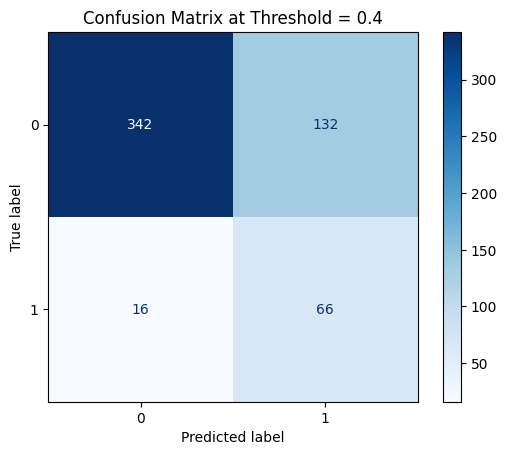

In [532]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix at Threshold = {threshold}')
plt.show()


## Pickle

In [533]:
import pickle

# Save
with open('final_logreg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Load
with open('final_logreg_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [534]:
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))

              precision    recall  f1-score   support

           0       0.94      0.78      0.86       474
           1       0.37      0.73      0.49        82

    accuracy                           0.78       556
   macro avg       0.66      0.76      0.67       556
weighted avg       0.86      0.78      0.80       556

